In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from networkx.algorithms.approximation import clique, vertex_cover
from networkx.algorithms.bipartite.covering import min_edge_cover

In [2]:
# pd.set_option('display.max_rows', 500)

### Preprocessing the 'Graph of Europe' data:
> Copy all European countries and read them into pandas.DataFrame

> Parse the table from "https://en.wikipedia.org/wiki/List_of_countries_and_territories_by_land_borders", using IMPORT_HTML() from googlesheets

> Read 'Land borders' data into pandas.DataFrame and then filter by countries

In [3]:
Europe = nx.Graph()
countries = pd.read_csv('countries.csv')
Europe.add_nodes_from(countries['country'])

# sheet_id = '1XqOtPkiE_Q0dfGSoyxrH730RkwrTczcRbDeJJpqRByQ'
# sheet_name = 'borders'
# url = f'https://docs.google.com/spreadsheets/d' \
#     '/1AYODVslftthH3aI8gS0d4wgyLZwwXMpD4bQOSv5M4GI/gviz/tq?tqx=out:csv&sheet={sheet_name}'
# df = pd.read_csv(url)

In [4]:
doc_id = '1AYODVslftthH3aI8gS0d4wgyLZwwXMpD4bQOSv5M4GI'
url = url = f'https://docs.google.com/spreadsheets/d/{doc_id}/export?format=csv'
df = pd.read_csv(url)
df = df.drop([0], axis=0)
df

,Country or territory\n*(Territories without full sovereignty in italics)* [2],Total length of land borders,Unnamed: 2,No. of distinct land borders,No. of distinct land neighbours,Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory*
1,* Abkhazia*,382,237,2,2,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
2,* Afghanistan*,"5,529","3,436",6,6,People's Republic of China: 76 km (47 mi)\n Ir...
3,* Albania*,720,450,4,4,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
4,* Algeria*,"6,47","4,02",7,7,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
5,* Andorra*,120,75,2,2,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...,...,...,...,...
201,* Vietnam*,"4,639","2,883",3,3,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
202,* Western Sahara*[5],"2,046","1,271",3,3,"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
203,* Yemen*,"1,746","1,085",2,2,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
204,* Zambia*,"5,667","3,521",8,8,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


Have to drop and rename some columns 

In [5]:
df.columns

Index(['Country or territory\n*(Territories without full sovereignty in italics)* [2]',
       'Total length of land borders', 'Unnamed: 2',
       'No. of distinct land borders', 'No. of distinct land neighbours',
       'Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory*'],
      dtype='object')

In [6]:
borders = df.rename(columns={'Country or territory\n*(Territories'
                   ' without full sovereignty in italics)* [2]': 
                   'country',
                   'Land border neighbours\nand border'
                   ' length\n'
                   '\n*(Territories without full sovereignty in italics) '
                   '[2](#) = No. of distinct \nland boundaries with that country or territory*': \
                   'neighbours'
                  }).drop(['Total length of land borders', 'Unnamed: 2'
                           ,'No. of distinct land borders', 'No. of distinct land neighbours']
                        , axis=1)
borders['country'] = borders['country'].str.replace('*', '').str.strip()
borders['country'] = borders['country'].str.replace(r'\[([0-9_]+)\]', '', regex=True) \
    .str.replace(r'\(([0-9_])+\)', '', regex=True)
# borders['neighbours'] = borders['neighbours'].str.split('\n')
borders.at[63, 'country'] = 'France'
borders.at[131, 'country'] = 'Netherlands'
borders

/var/folders/6d/jcsgnwtj1857x2zvzznd28jw0000gn/T/ipykernel_5901/2355719927.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  borders['country'] = borders['country'].str.replace('*', '').str.strip()


,country,neighbours
1,Abkhazia,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
2,Afghanistan,People's Republic of China: 76 km (47 mi)\n Ir...
3,Albania,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
4,Algeria,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
5,Andorra,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...
201,Vietnam,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
202,Western Sahara,"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
203,Yemen,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
204,Zambia,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


In [7]:
borders[['country']]

,country
1,Abkhazia
2,Afghanistan
3,Albania
4,Algeria
5,Andorra
...,...
201,Vietnam
202,Western Sahara
203,Yemen
204,Zambia


In [8]:
edges_df = countries.merge(borders, how='left')
edges_df['neighbours'] =  edges_df['neighbours'].str.split('\n')
edges_df['neighbours'] = edges_df['neighbours'].fillna("").apply(list)
# edges_df = edges_df.explode('neighbours')
edges_df

,country,neighbours
0,Armenia,"[Azerbaijan (6): 787 km (489 mi)[8], Georgia:..."
1,Albania,"[Greece: 282 km (175 mi), * Kosovo*:[4] 112 km..."
2,Andorra,"[France: 56.6 km (35.2 mi), Spain: 63.7 km (3..."
3,Austria,"[Czech Republic: 362 km (225 mi), Germany: 78..."
4,Belarus,"[Latvia: 141 km (88 mi), Lithuania: 502 km (3..."
5,Belgium,"[France: 620 km (390 mi), Germany (6):[12] 16..."
6,Bosnia and Herzegovina,"[Croatia (2): 932 km (579 mi), Montenegro: 22..."
7,Bulgaria,"[Greece: 494 km (307 mi), North Macedonia: 14..."
8,Croatia,"[Bosnia and Herzegovina (2): 932 km (579 mi), ..."
9,Cyprus,[* Akrotiri and Dhekelia*[20] (United Kingdom)...


In [9]:
for index, row in edges_df.iterrows():
    for neighbour in row['neighbours']:
        temp = neighbour.split(':')[0].replace('*', '')
        temp = re.sub("\[([0-9_]+)\]", "", temp)
        temp = re.sub("\(([0-9_])+\)", "", temp)
        temp = temp.strip()
        if temp in list(edges_df['country']):
            # print(row['country'], temp)
            Europe.add_edge(row['country'], temp)

#### 1a

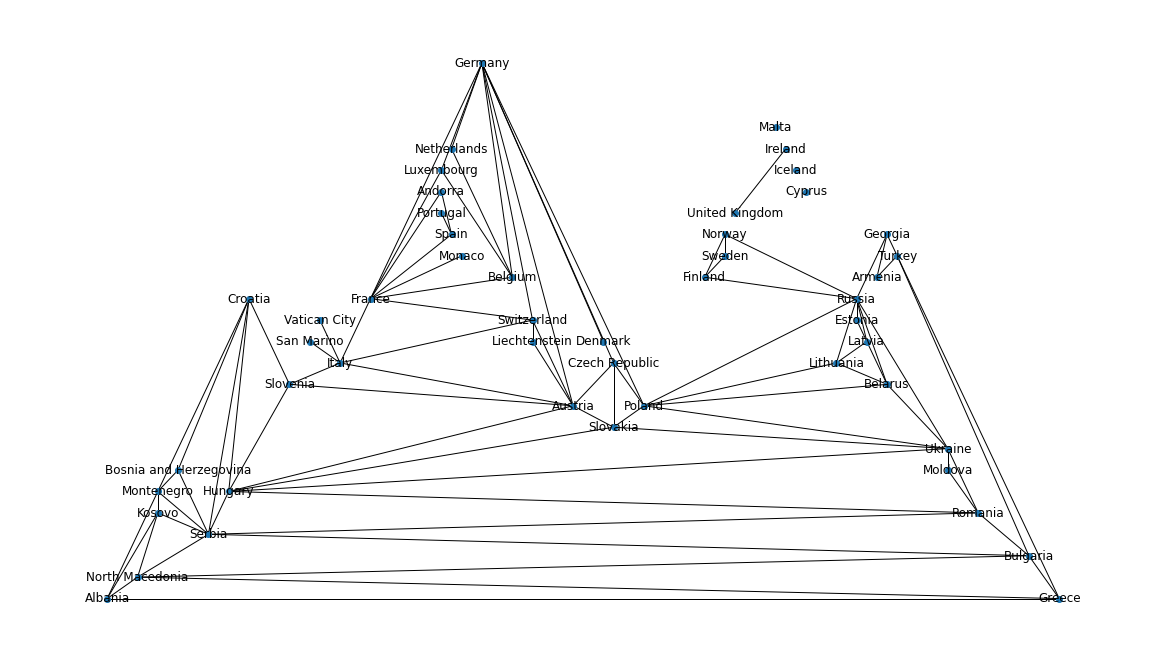

In [10]:
plt.figure(figsize=(16, 9))
nx.draw_planar(Europe, node_size=None, with_labels=True)

#### 1b

In [11]:
G = Europe.subgraph(max(nx.connected_components(Europe)))

In [12]:
print('|V|:', Europe.number_of_nodes())
print('|E|:', Europe.number_of_edges())

min_graph_degree = 1
max_graph_degree = 0
# degree = 0 is too dull
for country, degree in Europe.degree():
    if degree != 0:
        min_graph_degree = min(min_graph_degree, degree)
        max_graph_degree = max(max_graph_degree, degree)
print('Minimal graph degree:', min_graph_degree)
print('Maximal graph degree:', max_graph_degree)

print('Diameter:', nx.diameter(G))

print('Girth:', min([len(cycle) for cycle in nx.cycle_basis(G)]))

print(f'\nCenter:', nx.center(G))
print('Minimum vertex cut:' \
      , nx.minimum_node_cut(G))
print('Minimum edge cut:' \
      , nx.minimum_edge_cut(G))  

|V|: 49
|E|: 92
Minimal graph degree: 1
Maximal graph degree: 9
Diameter: 8
Girth: 3

Center: ['Austria', 'Belarus', 'Croatia', 'Czech Republic', 'Germany', 'Hungary', 'Lithuania', 'Poland', 'Russia', 'Slovakia', 'Slovenia', 'Switzerland', 'Ukraine']
Minimum vertex cut: {'Germany'}
Minimum edge cut: {('France', 'Monaco')}


#### 1c

Colors:
1    14
0    12
2    11
3     6
4     1
dtype: int64


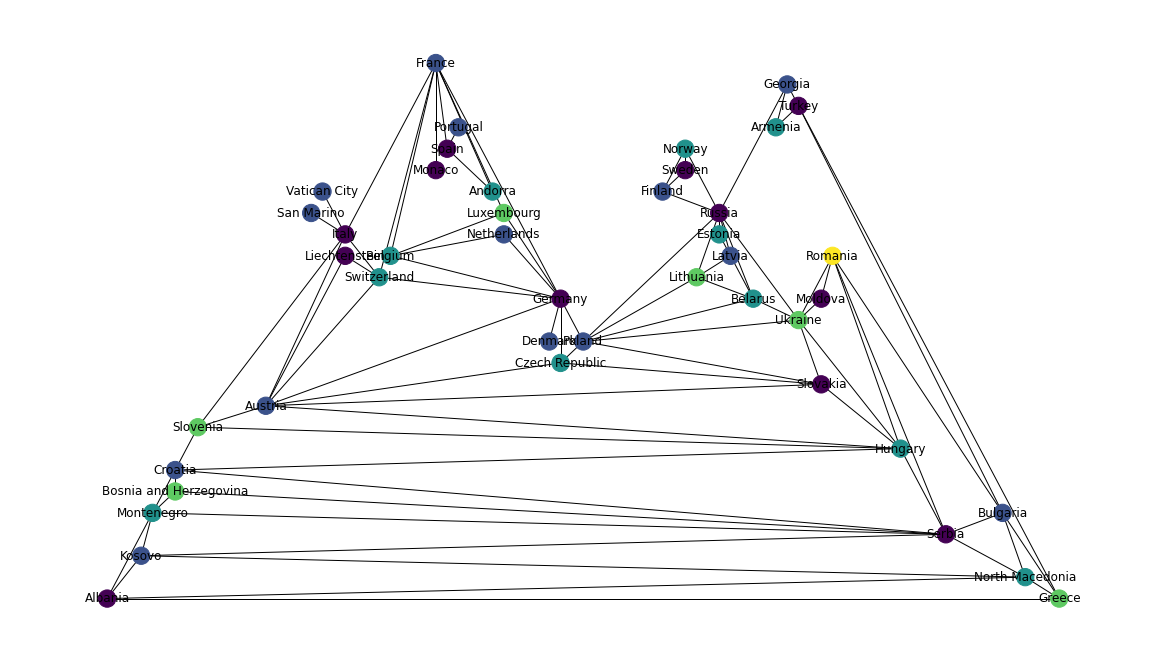

In [13]:
node_colors = nx.greedy_color(G)
color_map = []
for node in G:
    color_map.append(node_colors[node])
# color_map
print('Colors:')
print(pd.Series(node_colors.values()).value_counts())
plt.figure(figsize=(16, 9))
nx.draw_planar(G, node_color=color_map, with_labels=True)

#### 1d: TODO

In [14]:
# plt.figure(figsize=(16,9))
# nx.draw_planar(Europe, node_size=None, with_labels=True, edge_color=[1])
# colors = [1] * G.number_of_edges()

#### 1e

Maximum clique: {'Russia', 'Belarus', 'Ukraine', 'Poland'}


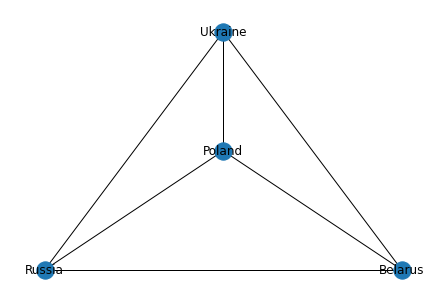

In [34]:
cliques = list(nx.find_cliques_recursive(G))
max_clique_size = 0
for element in cliques:
    max_clique_size = max(max_clique_size, len(element))
# max_clique_size
# for element in cliques:
#     if len(element) == max_clique_size:
#         print('Maximum clique:', element)
#         break
print('Maximum clique:', clique.max_clique(G))
nx.draw_planar(G.subgraph(clique.max_clique(G)), with_labels=True)

#### 1f

Maximal independent set: ['Poland', 'Netherlands', 'Liechtenstein', 'North Macedonia', 'Slovenia', 'Latvia', 'Romania', 'Luxembourg', 'Bosnia and Herzegovina', 'Monaco', 'Andorra', 'Vatican City', 'Sweden', 'Denmark', 'Georgia', 'San Marino', 'Portugal']
Size: 16


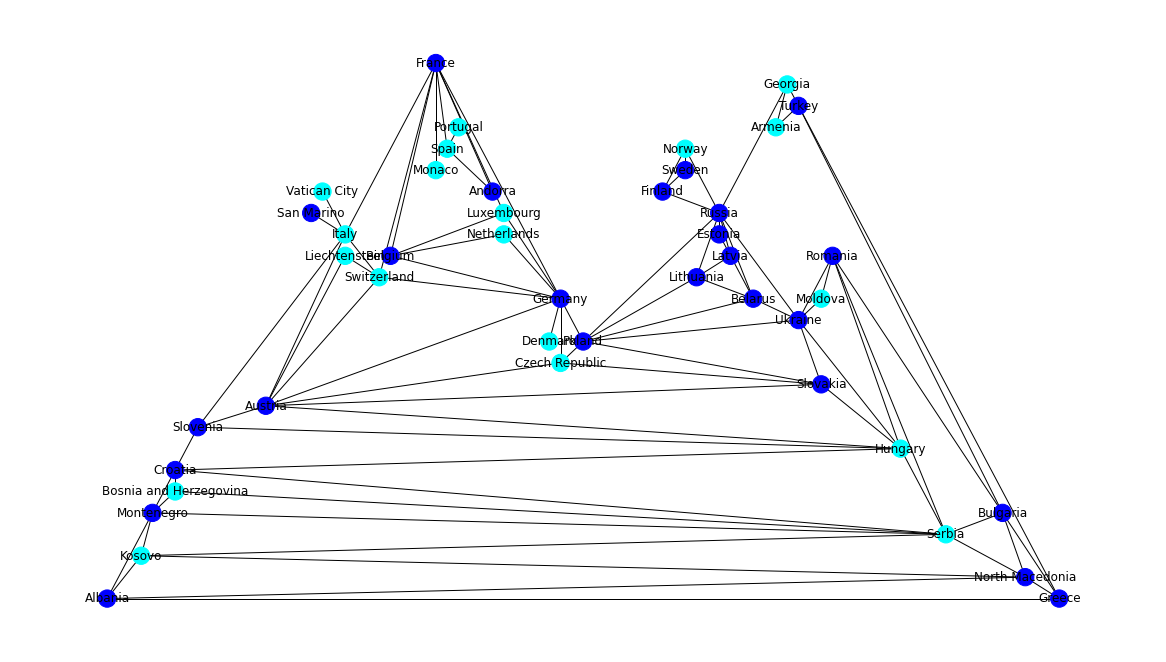

In [46]:
print('Maximal independent set:', nx.maximal_independent_set(G))
print('Size:', len(nx.maximal_independent_set(G)))

plt.figure(figsize=(16, 9))
colors = list()
colors= ['cyan' if node in nx.maximal_independent_set(G) else 'blue' for node in G.nodes()]
nx.draw_planar(G, node_color=colors, with_labels=True)

#### 1g

Maximum matching: {('Austria', 'Czech Republic'), ('Andorra', 'France'), ('Belarus', 'Latvia'), ('Liechtenstein', 'Switzerland'), ('Portugal', 'Spain'), ('Albania', 'Greece'), ('Bosnia and Herzegovina', 'Croatia'), ('Bulgaria', 'North Macedonia'), ('Italy', 'San Marino'), ('Lithuania', 'Poland'), ('Finland', 'Norway'), ('Belgium', 'Germany'), ('Kosovo', 'Montenegro'), ('Moldova', 'Ukraine'), ('Estonia', 'Russia'), ('Hungary', 'Romania'), ('Armenia', 'Georgia')}
Size: 17


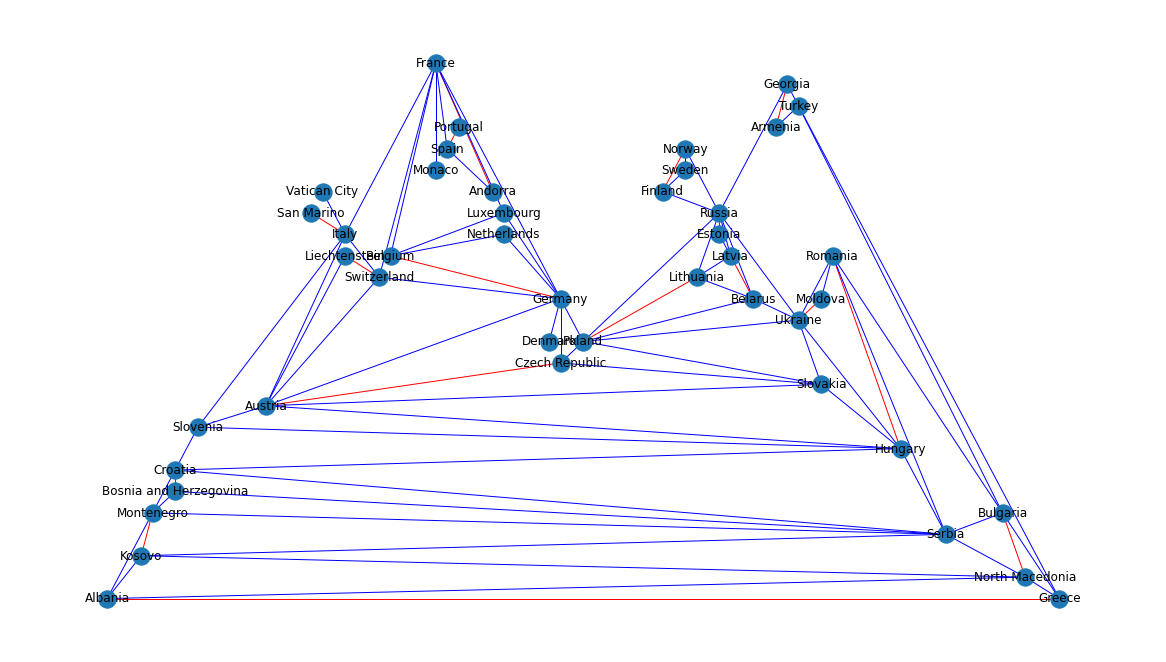

In [51]:
print('Maximum matching:', nx.maximal_matching(G))
print('Size:', len(nx.maximal_matching(G)))
plt.figure(figsize=(16, 9))
edge_colors = ['red' if edge in nx.maximal_matching(G) else 'blue' for edge in G.edges()]
nx.draw_planar(G, edge_color=edge_colors, with_labels=True)

#### 1h

31
Minimum vertex cover: {'Portugal', 'Finland', 'Germany', 'Russia', 'Greece', 'Austria', 'Ukraine', 'Czech Republic', 'Belgium', 'Italy', 'Croatia', 'Latvia', 'Albania', 'Lithuania', 'Bosnia and Herzegovina', 'Poland', 'North Macedonia', 'Moldova', 'Armenia', 'Liechtenstein', 'Norway', 'Belarus', 'Georgia', 'France', 'Romania', 'Hungary', 'Montenegro', 'Andorra', 'Estonia', 'Kosovo', 'Bulgaria'}


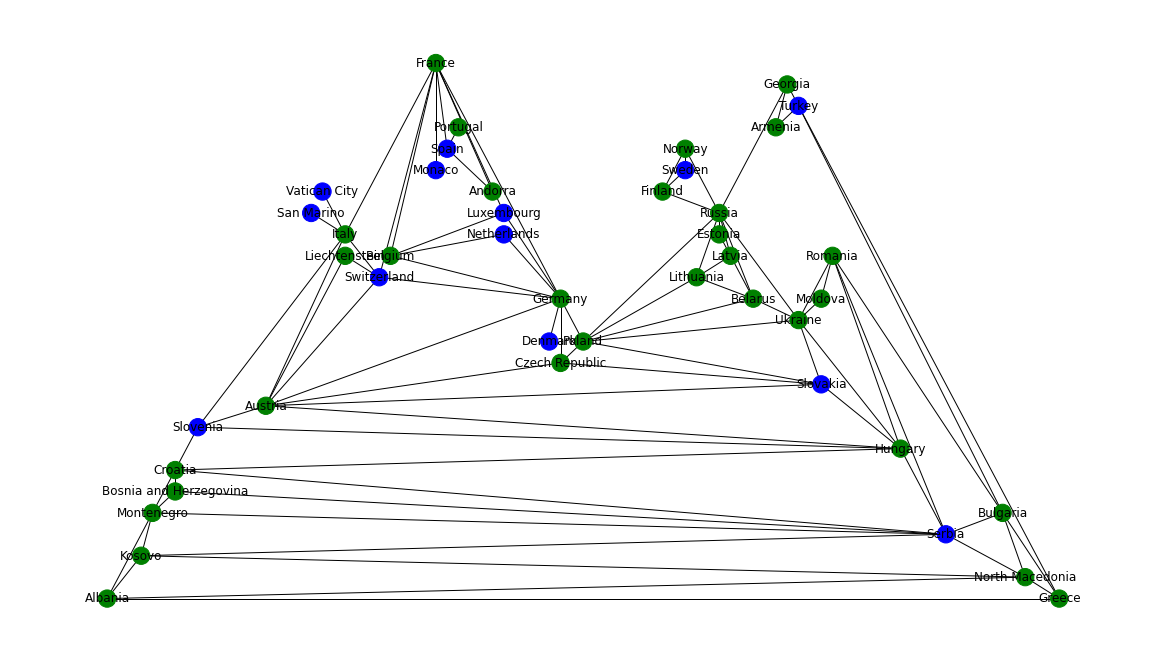

In [54]:
print(len(vertex_cover.min_weighted_vertex_cover(G)))
print('Minimum vertex cover:', vertex_cover.min_weighted_vertex_cover(G))
plt.figure(figsize=(16, 9))
colors = ['green' if vertex in vertex_cover.min_weighted_vertex_cover(G) 
         else 'blue' for vertex in G.nodes()]
nx.draw_planar(G, node_color=colors, with_labels=True)

#### 1i: TODO

In [20]:
# for component in nx.connected_components(Europe):
#     print(min_edge_cover(Europe.subgraph(component)))
# test = nx.Graph()
# test.add_nodes_from([1, 2, 3])
# test.add_edges_from([(1, 2), (2, 3), (3, 1)])
# min_edge_cover(test)


#### 1j: TODO

In [21]:
nx.is_k_edge_connected(Europe, 2)

False

#### 1m

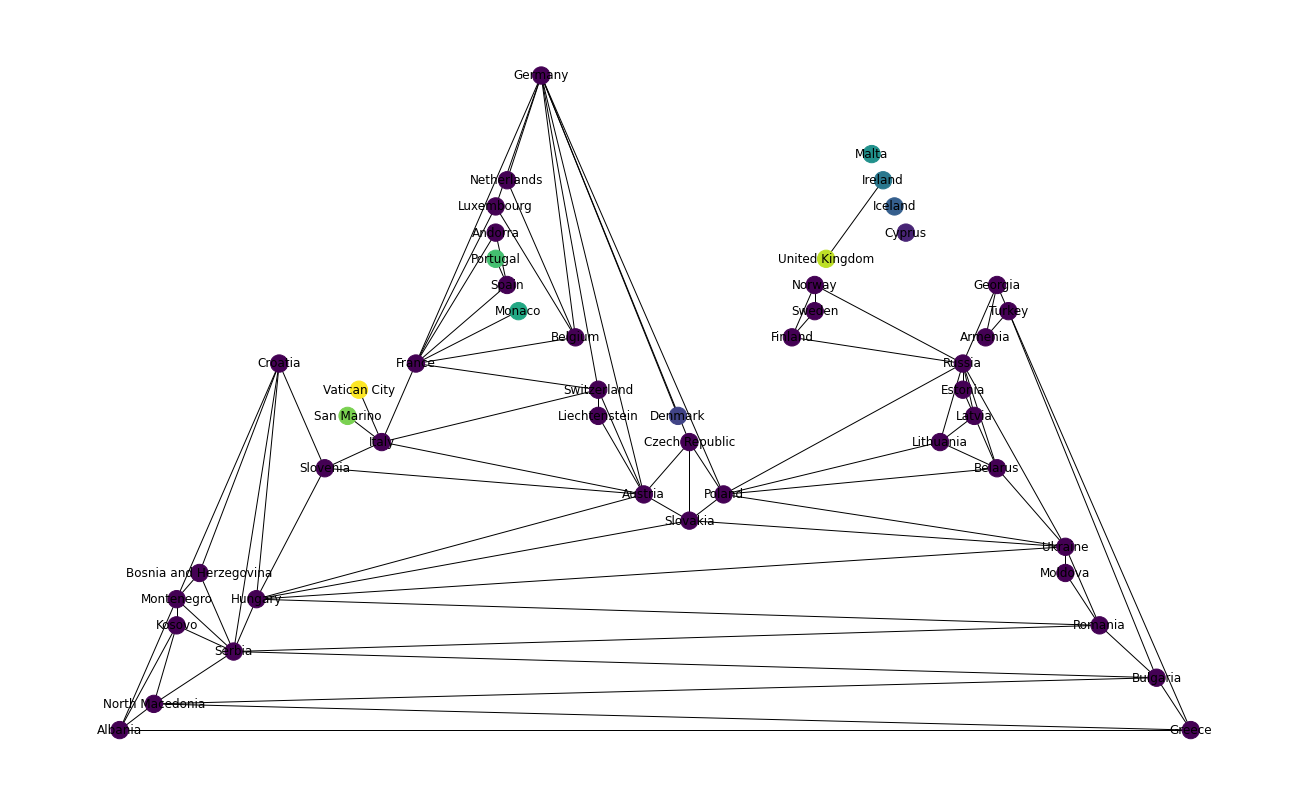

In [78]:
plt.figure(figsize=(18, 11))
node_colors = dict()
color = 0
for component in nx.k_edge_components(Europe, 2):
# #     nx.draw(component, with_labels=True)
#     print(len(component))
    for node in component:
        node_colors[node] = color
    color += 1 
colors = list()
nx.draw_planar(Europe, node_color=[node_colors[node] for node in Europe.nodes()], with_labels=True)


#### 1